In [1]:
%reload_ext autoreload
%autoreload 2
%aimport -time -typing -numpy -torch -tqdm -matplotlib -matplotlib.pyplot -pickle

In [2]:
import numpy as np
import scipy.sparse as sp
import grakel
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from jkutils.misc import pickle_cache

from gtn.dataloader.io import load_from_npz, save_to_npz
from gtn.dataloader.graphcollection import DistanceMatrix

/nfs/staff-ssd/klicpera/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/nfs/staff-ssd/klicpera/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.lfw module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load and convert data

In [5]:
gcolls = {}
for min_nodes in [100, 1000, 10_000]:
    gcolls[min_nodes] = {}
    for dataset in ['train', 'val', 'test']:
        gcolls[min_nodes][dataset] = load_from_npz(f"../raw/pref_att_{min_nodes}_nh_{dataset}.npz")

In [6]:
def spgraph_to_grakel_graph(graph):
    edge_dict = list(zip(*graph.adj_matrix.nonzero()))
    node_label_dict = dict(zip(range(graph.num_nodes()), graph.attr_matrix.flatten().astype(np.int)))
    if graph.edge_attr_matrix is not None:
        edge_label_dict = dict(zip(zip(*graph.adj_matrix.nonzero()), graph.edge_attr_matrix.flatten().astype(np.int)))
        return grakel.Graph(edge_dict, node_label_dict, edge_label_dict)
    else:
        return grakel.Graph(edge_dict, node_label_dict)

In [7]:
grakel_graphs = {}
for k1, gcolls_size in gcolls.items():
    grakel_graphs[k1] = {}
    for k2, gcoll_dataset in gcolls_size.items():
        grakel_graphs[k1][k2] = []
        for graph in tqdm(gcoll_dataset):
            grakel_graphs[k1][k2].append(spgraph_to_grakel_graph(graph))

# Select kernel

In [18]:
pm = grakel.PyramidMatch(normalize=True, L=4, d=6)

In [21]:
%time pm.fit_transform(grakel_graphs[10000]['train'][:3])

CPU times: user 59.9 s, sys: 5.11 s, total: 1min 4s
Wall time: 19.2 s


array([[1.        , 0.60928461, 0.64456538],
       [0.60928461, 1.        , 0.94517424],
       [0.64456538, 0.94517424, 1.        ]])

In [22]:
kernel = pm

In [23]:
def calc_gram_mats(graphs):
    gram_mats = {}
    for k1, graphs_size in graphs.items():
        gram_mats[k1] = {}
        for k2, graphs_dataset in graphs_size.items():
            print(f"{k1}, {k2}")
            gram_mats[k1][k2] = kernel.fit_transform(graphs_dataset)
    return gram_mats

In [24]:
# simple
gram_mats = pickle_cache('gram_mats_pm.pkl', calc_gram_mats, fn_args=[grakel_graphs])

# count_sensitive
# gram_mats_cs = pickle_cache('gram_mats_cs.pkl', calc_gram_mats, fn_args=[grakel_graphs])

100, train
100, val
100, test
1000, train
1000, val
1000, test
10000, train
10000, val
10000, test


In [25]:
gram_mats[10000]['train']

array([[1.        , 0.60928461, 0.64456538, ..., 0.68351114, 0.68333495,
        0.66732499],
       [0.60928461, 1.        , 0.94517424, ..., 0.89131877, 0.89155569,
        0.9129366 ],
       [0.64456538, 0.94517424, 1.        , ..., 0.94298766, 0.94323832,
        0.96583798],
       ...,
       [0.68351114, 0.89131877, 0.94298766, ..., 1.        , 0.99879653,
        0.97627595],
       [0.68333495, 0.89155569, 0.94323832, ..., 0.99879653, 1.        ,
        0.97653547],
       [0.66732499, 0.9129366 , 0.96583798, ..., 0.97627595, 0.97653547,
        1.        ]])

# Convert to distances

In [36]:
dists = {}
for k1, grams_size in gram_mats.items():
    dists[k1] = {}
    for k2, gram in grams_size.items():
        # Non-normalized: dist2 = (np.diagonal(gram_mat)[:, None] + np.diagonal(gram_mat)[None, :]) / 2 - gram_mat
        dists[k1][k2] = np.sqrt(1 - gram)

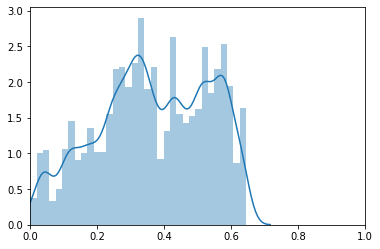

In [31]:
sns.distplot(dists[10000]['train'].flatten())
plt.xlim(0, 1)
plt.show()

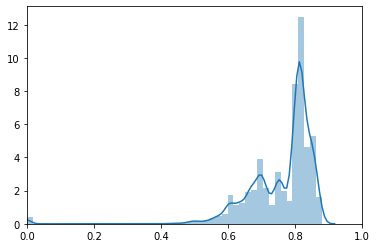

In [190]:
sns.distplot(dists[10000]['train'].flatten())
plt.xlim(0, 1)
plt.show()

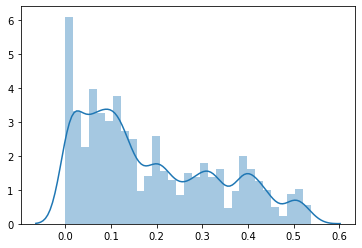

In [32]:
# Triangle inequality doesn't hold -> no!
dist_b = -np.log(gram_mats[10000]['train'])
sns.distplot(dist_b.flatten())
plt.show()

In [37]:
# Test metric properties
for dists_size in dists.values():
    for dist_mat in dists_size.values():
        assert np.all(dist_mat >= 0)
        assert np.all(np.where(dist_mat == 0)[0] == np.where(dist_mat == 0)[1])
        assert np.all(dist_mat == dist_mat.T)
        assert np.all(dist_mat[:, :, None] + dist_mat[None, :, :] >= dist_mat[:, None, :])

# Save distances

In [34]:
gcolls[100]['train'].dists

DistanceMatrix(
[[0.         0.9178094  0.92983264 ... 0.57583857 0.93909967 0.9449905 ]
 [0.9178094  0.         0.9431922  ... 0.92172015 0.95559525 0.9628603 ]
 [0.92983264 0.9431922  0.         ... 0.925981   0.9178702  0.91684616]
 ...
 [0.57583857 0.92172015 0.925981   ... 0.         0.93791014 0.9440034 ]
 [0.93909967 0.95559525 0.9178702  ... 0.93791014 0.         0.93031013]
 [0.9449905  0.9628603  0.91684616 ... 0.9440034  0.93031013 0.        ]])

In [38]:
dists[min_nodes][dataset]

array([[0.        , 0.28107779, 0.6246718 , ..., 0.51657898, 0.40397211,
        0.02685876],
       [0.28107779, 0.        , 0.58131349, ..., 0.45170653, 0.30251062,
        0.28104176],
       [0.6246718 , 0.58131349, 0.        , ..., 0.41024299, 0.52089229,
        0.62465445],
       ...,
       [0.51657898, 0.45170653, 0.41024299, ..., 0.        , 0.35202735,
        0.51657035],
       [0.40397211, 0.30251062, 0.52089229, ..., 0.35202735, 0.        ,
        0.40395806],
       [0.02685876, 0.28104176, 0.62465445, ..., 0.51657035, 0.40395806,
        0.        ]])

In [39]:
for min_nodes in [100, 1000, 10_000]:
    for dataset in ['train', 'val', 'test']:
        gcolls[min_nodes][dataset].dists = DistanceMatrix(dists[min_nodes][dataset])
        save_to_npz(f"../raw/pref_att_{min_nodes}_pm_{dataset}.npz", gcolls[min_nodes][dataset])